# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences text or speech).

Another common term for NLP problems is sequence to sequence problems (seq2seq).

## Check for gpu

In [1]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-08-17 16:30:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-17 16:30:24 (75.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster).

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-08-17 16:30:29--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.187.128, 64.233.188.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  1000KB/s    in 0.6s    

2023-08-17 16:30:30 (1000 KB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python.

But I prefer to get visual trraight away.

So another way to do this is to use pandas...

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# How many examples of each class?
train_df["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [9]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
text:
My first staining attempt was a disaster https://t.co/buDmKE3nNf

---

Target: 1 (real disaster)
text:
Can't believe more people in their mid 20's don't have high blood pressure. Life is stressful. #DecisionsOnDecisions

---

Target: 0 (not real disaster)
text:
.@AIGinsurance CEO: Divestitures and #Catastrophe Losses Temper Q2 #Results http://t.co/2y2wZk1FrM

---

Target: 1 (real disaster)
text:
Obama Declares Disaster for Typhoon-Devastated Saipan: Obama signs disaster declaration for Northern Marians a... http://t.co/PC8BvufLFJ

---

Target: 0 (not real disaster)
text:
@justinbieber @ArianaGrande IM SCREAMING

---



### Split data into training and validation sets

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # use 0% of training data for validation
                                                                            random_state=42)

In [12]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into number

When dealing with text problem, one of the first thing you'l have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character) to number.
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned).

### Text vectorization (tokenization)

In [14]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=10000, # how many words in the vocabulary (automaticlly add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create group of n-words?
                                    output_mode="int", # how to match tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be?
                                    pad_to_max_tokens=True)

In [16]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [17]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of woords to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [18]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [19]:
# Create a samples sentence and tokenize it
sample_sentence = "There's a flood in my streeet"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [20]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n \n Vectorized version:")
text_vectorizer(random_sentence)

Original text:
 Yea so I'm gonna demolish all those boundaries that I seem to have 'unconsciously' set for myself with negative thoughts!        
 
 Vectorized version:


<tf.Tensor: shape=(15,), dtype=int64, numpy=
array([3235,   28,   32,  319,  516,   44,  161, 6076,   16,    8, 4670,
          5,   24, 7226,  284])>

In [21]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our vocabulary
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make our embedding, we;re going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [22]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                            output_dim=128, # output shape
                            embeddings_initializer="uniform",
                            input_length=max_length # how long is each input?
                            )
embedding

In [23]:
# Get a random sentences from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\n Embedded version: ")

# Embedded the random sentence (turn it into dense vector of fixed size)
sample_embedded = embedding(text_vectorizer([random_sentence]))
sample_embedded

Original text:
 the future of america #GamerGate http://t.co/UhF7NyAbSw        

 Embedded version: 


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.03144217, -0.04366397,  0.00851459, ..., -0.03255512,
         -0.03234304,  0.02432689],
        [ 0.02271516, -0.04844141,  0.01777489, ..., -0.04853004,
          0.03573683, -0.03500361],
        [-0.009059  ,  0.01328547, -0.01307911, ..., -0.02448707,
         -0.03469926,  0.04467852],
        ...,
        [-0.00977253, -0.01192404,  0.03216051, ...,  0.021855  ,
         -0.00497382, -0.03097373],
        [-0.00977253, -0.01192404,  0.03216051, ...,  0.021855  ,
         -0.00497382, -0.03097373],
        [-0.00977253, -0.01192404,  0.03216051, ...,  0.021855  ,
         -0.00497382, -0.03097373]]], dtype=float32)>

In [24]:
# Check out a single token's embedding
sample_embedded[0][0], sample_embedded[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.03144217, -0.04366397,  0.00851459, -0.03342506, -0.04049055,
        -0.04212365, -0.0098583 ,  0.03980375,  0.01527334, -0.02287904,
        -0.02520254,  0.02859911, -0.01769053,  0.03234288, -0.03445994,
         0.03718517, -0.02276814, -0.03463814, -0.02770585,  0.03273633,
         0.01041811, -0.00676481, -0.00113356, -0.01698947,  0.00240181,
         0.03364316,  0.01899481,  0.01655627,  0.00086188,  0.04089359,
         0.03572328,  0.00077949,  0.03971788, -0.02423753, -0.01987245,
        -0.00938933,  0.04959512, -0.00386856,  0.00413752,  0.02979125,
         0.00532472,  0.02374885,  0.01441801, -0.0482638 ,  0.01936806,
         0.03944919,  0.01609394,  0.04860821,  0.04257358, -0.029971  ,
        -0.02199792,  0.03356436,  0.0469471 ,  0.0039557 , -0.0109883 ,
         0.0003104 ,  0.03490904, -0.00318249, -0.00710749, -0.01169508,
         0.01489658,  0.00067372, -0.01268655,  0.04739897,  0.00525028,
  

## Modeling a text dataset (running a series of experiments)

Now we've goot a way to turn our text sequences into numbers, it's time to start building a series of modeling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline), this is from Sklearn ML map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM Model
* Model 3: GRU Model
* Model 4: Bidirectional-LSTM Model
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to approach all of these?

Use the standard steps in modeling with tensoflow:

* Craete a model
* Build a model
* Fit a model
* Evaluate our model

### Model 0: Getting a baseline

As with all machine learning modeling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> 🔑 **Note:** It's commmon practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modeling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words too numbers using tfidf
    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [27]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however, this will be cumbersome and could easily be fixed with a function...

Let's create one to compare our model's predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

For a deep overview of many different evaluation methods, see the Sklearn documentation.

In [28]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall, and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [29]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

In [30]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [31]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer, want binary outputs so use sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [32]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [33]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [34]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20230817-163032
Epoch 1/5
215/215 [==============================] - 7s 25ms/step - loss: 0.6118 - accuracy: 0.6922 - val_loss: 0.5355 - val_accuracy: 0.7533
Epoch 2/5
215/215 [==============================] - 5s 23ms/step - loss: 0.4405 - accuracy: 0.8196 - val_loss: 0.4701 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 6s 29ms/step - loss: 0.3463 - accuracy: 0.8600 - val_loss: 0.4618 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 5s 21ms/step - loss: 0.2843 - accuracy: 0.8907 - val_loss: 0.4636 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 6s 29ms/step - loss: 0.2374 - accuracy: 0.9139 - val_loss: 0.4800 - val_accuracy: 0.7835


In [35]:
# Check the result
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4800 - accuracy: 0.7835


[0.48002704977989197, 0.7834645509719849]

In [36]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 2ms/step


(762, 1)

In [37]:
model_1_pred_probs[0]

array([0.37388948], dtype=float32)

In [38]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [39]:
# Calculate our model_1 results
model_1_results = calculate_results(val_labels,
                                    model_1_preds)
model_1_results

{'accuracy': 78.34645669291339,
 'precision': 0.7884290282979772,
 'recall': 0.7834645669291339,
 'f1': 0.7803444000779524}

In [40]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [41]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing leanred embeddings

In [42]:
# Get the vocabulary from the text vectorization
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [43]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [44]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for 5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (output_dim of our embedding layer)

(10000, 128)


Now we've goot the embedding matrix our model has learned to represent out tokens, let's see how we can visualie it.

To do so, TensorFlow has a handy tool called prjector: https://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/text/guide/word_embeddings

In [45]:
# Create embedding files (we got this from TensorFlow's word embeddings documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [46]:
# # Download files from Colab to upload to projector
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

## Recurrent Neural Network (RNN's)

RNN's are useful for sequence data

The premise of a recurrent neural network is to use the representation of a previuos input to aid the representation of a later input.

### Model 2: LST<

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```

In [47]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.LSTM(units=64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to set return_sequences=True
x = layers.LSTM(64)(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [48]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [49]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [50]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230817-163116
Epoch 1/5
215/215 [==============================] - 12s 39ms/step - loss: 0.2220 - accuracy: 0.9206 - val_loss: 0.5144 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 9s 40ms/step - loss: 0.1588 - accuracy: 0.9407 - val_loss: 0.6072 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 8s 39ms/step - loss: 0.1286 - accuracy: 0.9518 - val_loss: 0.7357 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 10s 45ms/step - loss: 0.1078 - accuracy: 0.9587 - val_loss: 0.8717 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 8s 38ms/step - loss: 0.0876 - accuracy: 0.9657 - val_loss: 0.9086 - val_accuracy: 0.7769


In [51]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


array([[1.37459915e-02],
       [8.28098416e-01],
       [9.99731123e-01],
       [2.87936218e-02],
       [4.89211758e-04],
       [9.99149442e-01],
       [6.46462679e-01],
       [9.99819517e-01],
       [9.99701023e-01],
       [4.12169725e-01]], dtype=float32)

In [52]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [53]:
# Calculate model 2 result
model_2_results = calculate_results(val_labels,
                                    model_2_preds)
model_2_results

{'accuracy': 77.69028871391076,
 'precision': 0.7789562668302826,
 'recall': 0.7769028871391076,
 'f1': 0.7747522807746444}

In [54]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.


In [55]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
# x = layers.GRU(64, return_sequences=True)(x) # If you want to stack recurrent layers on top of each other, you need return_sequences=True
# x = layers.LSTM(64, return_sequences=True)(x)
# x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x)
# x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [56]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [57]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [58]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20230817-163243
Epoch 1/5
215/215 [==============================] - 12s 42ms/step - loss: 0.1601 - accuracy: 0.9353 - val_loss: 0.7719 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 8s 39ms/step - loss: 0.0852 - accuracy: 0.9699 - val_loss: 0.8144 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 8s 36ms/step - loss: 0.0744 - accuracy: 0.9724 - val_loss: 0.8929 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 9s 43ms/step - loss: 0.0627 - accuracy: 0.9753 - val_loss: 0.9890 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 8s 39ms/step - loss: 0.0583 - accuracy: 0.9762 - val_loss: 1.1555 - val_accuracy: 0.7690


In [59]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


array([[3.4714289e-02],
       [6.5337825e-01],
       [9.9971747e-01],
       [5.8036581e-02],
       [1.0527928e-04],
       [9.9963385e-01],
       [7.1439260e-01],
       [9.9988264e-01],
       [9.9977571e-01],
       [9.6515924e-01]], dtype=float32)

In [60]:
# Convert model pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [61]:
# Calculate model 3 results
model_3_results = calculate_results(val_labels,
                                    model_3_preds)
model_3_results

{'accuracy': 76.9028871391076,
 'precision': 0.769557843731072,
 'recall': 0.7690288713910761,
 'f1': 0.7675415573053368}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however, a bidirectional RNN goes from right to left as well as left to right.

In [62]:
# Build a bidirectional RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [63]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [64]:
# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [65]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230817-163330
Epoch 1/5
215/215 [==============================] - 16s 55ms/step - loss: 0.1092 - accuracy: 0.9650 - val_loss: 0.9456 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 11s 53ms/step - loss: 0.0567 - accuracy: 0.9756 - val_loss: 0.9806 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 11s 53ms/step - loss: 0.0476 - accuracy: 0.9796 - val_loss: 1.4028 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 12s 54ms/step - loss: 0.0434 - accuracy: 0.9784 - val_loss: 1.2438 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 11s 53ms/step - loss: 0.0382 - accuracy: 0.9819 - val_loss: 1.4647 - val_accuracy: 0.7638


In [66]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 8ms/step


array([[1.4797730e-03],
       [8.0759060e-01],
       [9.9996549e-01],
       [1.6605556e-01],
       [1.1566425e-05],
       [9.9985707e-01],
       [9.1834658e-01],
       [9.9998754e-01],
       [9.9998087e-01],
       [9.6559572e-01]], dtype=float32)

In [67]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [68]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(val_labels,
                                    model_4_preds)
model_4_results

{'accuracy': 76.37795275590551,
 'precision': 0.7639261289761722,
 'recall': 0.7637795275590551,
 'f1': 0.7624822674694383}

## Convolution Neural Networks for Text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height x width)... however, our text data is 1D.

Previously we've Conv2D for our image data but now we're going to use Conv1D.

The typical structure of a Conv1D model for sequence (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)
```

### Model 5: Conv1D

In [69]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # this is also refered to as an ngram of 5 (meaning it look at 5 words at a time)
                        activation="relu",
                        padding="valid") # default = "valid", the output is smaller than the input shape, "same" means output is same as input
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivilant to "get the most important feature" or "get the feature with the highest"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [70]:
# embedding_test

In [71]:
# conv_1d_output

In [72]:
# max_pool_output

In [73]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  activation="relu",
                  padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our Conv1D model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [74]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230817-163458
Epoch 1/5
215/215 [==============================] - 8s 32ms/step - loss: 0.1237 - accuracy: 0.9564 - val_loss: 0.9369 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 7s 31ms/step - loss: 0.0713 - accuracy: 0.9729 - val_loss: 1.1033 - val_accuracy: 0.7585
Epoch 3/5
215/215 [==============================] - 6s 28ms/step - loss: 0.0605 - accuracy: 0.9768 - val_loss: 1.1589 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 7s 31ms/step - loss: 0.0555 - accuracy: 0.9783 - val_loss: 1.2081 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 6s 29ms/step - loss: 0.0511 - accuracy: 0.9784 - val_loss: 1.2622 - val_accuracy: 0.7507


In [75]:
# Make some predictions with out Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[8.2145214e-02],
       [9.8204279e-01],
       [9.9984872e-01],
       [6.2306438e-02],
       [8.5494264e-08],
       [9.9960047e-01],
       [9.9003661e-01],
       [9.9992818e-01],
       [9.9999952e-01],
       [9.2858630e-01]], dtype=float32)

In [76]:
# Convert model 5 pred prbs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [77]:
# Evaluate model 5 predictions
model_5_results = calculate_results(val_labels,
                                    model_5_preds)
model_5_results

{'accuracy': 75.06561679790026,
 'precision': 0.7502819757880341,
 'recall': 0.7506561679790026,
 'f1': 0.7497154845080983}

In [78]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've builded a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

See how the USE was created here: https://arxiv.org/abs/1803.11175

In [79]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you call the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01292787  0.02773639  0.06031748 -0.03082666  0.04085579  0.06104278
  0.03465945  0.03872614  0.00220414  0.05087209  0.02349292 -0.03255888
  0.00528576  0.08116584  0.08183495 -0.02703606  0.04374349 -0.06453941
  0.04762025 -0.0297901  -0.02492323  0.05321782  0.05149575  0.01965656
  0.01111771 -0.05227506 -0.02703937  0.03959988 -0.03832492 -0.02204785
 -0.03369696  0.0448244  -0.00784027 -0.05345516  0.01174269 -0.08251122
  0.00426629  0.04368501 -0.00048564 -0.07316951 -0.00177663 -0.04224257
  0.00208975  0.06379575 -0.11047049 -0.01988985 -0.01318034 -0.01679368
 -0.02463584  0.04850979], shape=(50,), dtype=float32)


In [80]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentences_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                         input_shape=[],
                                         dtype=tf.string,
                                         trainable=False,
                                         name="USE")

In [81]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentences_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [82]:
# Train a classifier on top of USE pretrianed embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230817-163617
Epoch 1/5
215/215 [==============================] - 8s 20ms/step - loss: 0.5032 - accuracy: 0.7841 - val_loss: 0.4503 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4153 - accuracy: 0.8162 - val_loss: 0.4396 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4005 - accuracy: 0.8209 - val_loss: 0.4375 - val_accuracy: 0.8071
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3933 - accuracy: 0.8253 - val_loss: 0.4328 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3844 - accuracy: 0.8304 - val_loss: 0.4284 - val_accuracy: 0.8163


In [83]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.19301249],
       [0.83256674],
       [0.9904425 ],
       [0.20555498],
       [0.765868  ],
       [0.7530152 ],
       [0.98217887],
       [0.97872895],
       [0.94954413],
       [0.10785794]], dtype=float32)

In [84]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [85]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels,
                                    model_6_preds)
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8168258096697188,
 'recall': 0.8162729658792651,
 'f1': 0.8154272806950674}

In [86]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 7: TF Hub Pretrained but with 10% of training data

Transfer learning really help when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

In [87]:
## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text","target"]].sample(frac=0.1, random_state=42)
# # train_10_percent.head(), len(train_10_percent)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

> 🔑 **Note:** Be *very* careful when creating training/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained 10% of data outperfoming the same model trained on 100% of data) trust your gut and go back through to find where the error may lie.

In [88]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_labels_10_percent)

685

In [89]:
# Check the number of each label in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [90]:
# Check the number of targets in out subset of data
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [91]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model the same as a previous model you've created you can use the `tf.keras.models.clone_model()` method.

In [92]:
# Let's build a model the same as model_6
# model_7 = tf.keras.models.clone_model(model_6)
model_7 = tf.keras.Sequential([
    sentences_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_7_USE")

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [93]:
# Fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20230817-163642
Epoch 1/5
22/22 [==============================] - 4s 93ms/step - loss: 0.6735 - accuracy: 0.6569 - val_loss: 0.6516 - val_accuracy: 0.7310
Epoch 2/5
22/22 [==============================] - 1s 28ms/step - loss: 0.6030 - accuracy: 0.8161 - val_loss: 0.5920 - val_accuracy: 0.7598
Epoch 3/5
22/22 [==============================] - 1s 28ms/step - loss: 0.5255 - accuracy: 0.8234 - val_loss: 0.5343 - val_accuracy: 0.7848
Epoch 4/5
22/22 [==============================] - 1s 28ms/step - loss: 0.4634 - accuracy: 0.8248 - val_loss: 0.5037 - val_accuracy: 0.7743
Epoch 5/5
22/22 [==============================] - 1s 30ms/step - loss: 0.4238 - accuracy: 0.8380 - val_loss: 0.4890 - val_accuracy: 0.7808


In [94]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 11ms/step


array([[0.2086203 ],
       [0.57832736],
       [0.92964154],
       [0.35090435],
       [0.5170321 ],
       [0.7124385 ],
       [0.89627135],
       [0.832709  ],
       [0.8601956 ],
       [0.16974522]], dtype=float32)

In [95]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [96]:
# Evaluate model_7 predictions
model_7_results = calculate_results(val_labels,
                                    model_7_preds)
model_7_results

{'accuracy': 78.08398950131233,
 'precision': 0.7823342077218286,
 'recall': 0.7808398950131233,
 'f1': 0.7790338643605079}

In [97]:
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8168258096697188,
 'recall': 0.8162729658792651,
 'f1': 0.8154272806950674}

## Comparing the performance of each of our models


In [98]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                 "1_simple_dense": model_1_results,
                                 "2_lstm": model_2_results,
                                 "3_gru": model_3_results,
                                 "4_bidirectional": model_4_results,
                                 "5_conv1d": model_5_results,
                                 "6_tf_hub_use_encoder": model_6_results,
                                 "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.346457,0.788429,0.783465,0.780344
2_lstm,77.690289,0.778956,0.776903,0.774752
3_gru,76.902887,0.769558,0.769029,0.767542
4_bidirectional,76.377953,0.763926,0.763780,0.762482
5_conv1d,75.065617,0.750282,0.750656,0.749715
6_tf_hub_use_encoder,81.627297,0.816826,0.816273,0.815427
7_tf_hub_use_encoder_10_percent,78.083990,0.782334,0.780840,0.779034


In [99]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.783465,0.788429,0.783465,0.780344
2_lstm,0.776903,0.778956,0.776903,0.774752
3_gru,0.769029,0.769558,0.769029,0.767542
4_bidirectional,0.763780,0.763926,0.763780,0.762482
5_conv1d,0.750656,0.750282,0.750656,0.749715
6_tf_hub_use_encoder,0.816273,0.816826,0.816273,0.815427
7_tf_hub_use_encoder_10_percent,0.780840,0.782334,0.780840,0.779034


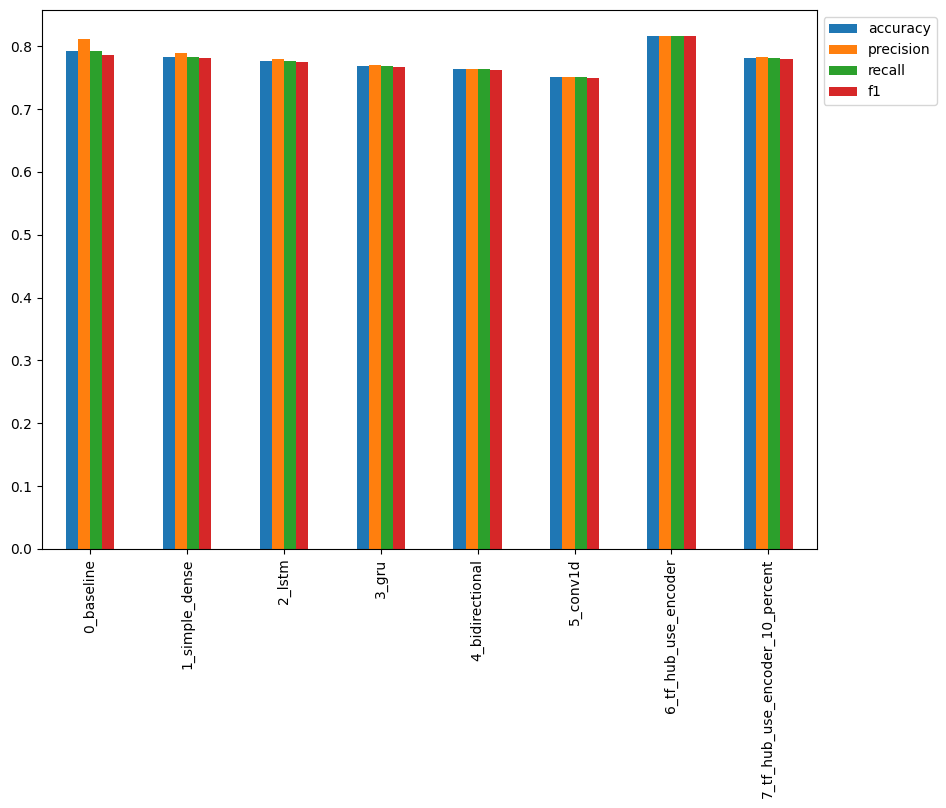

In [100]:
# Plot and comaper all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

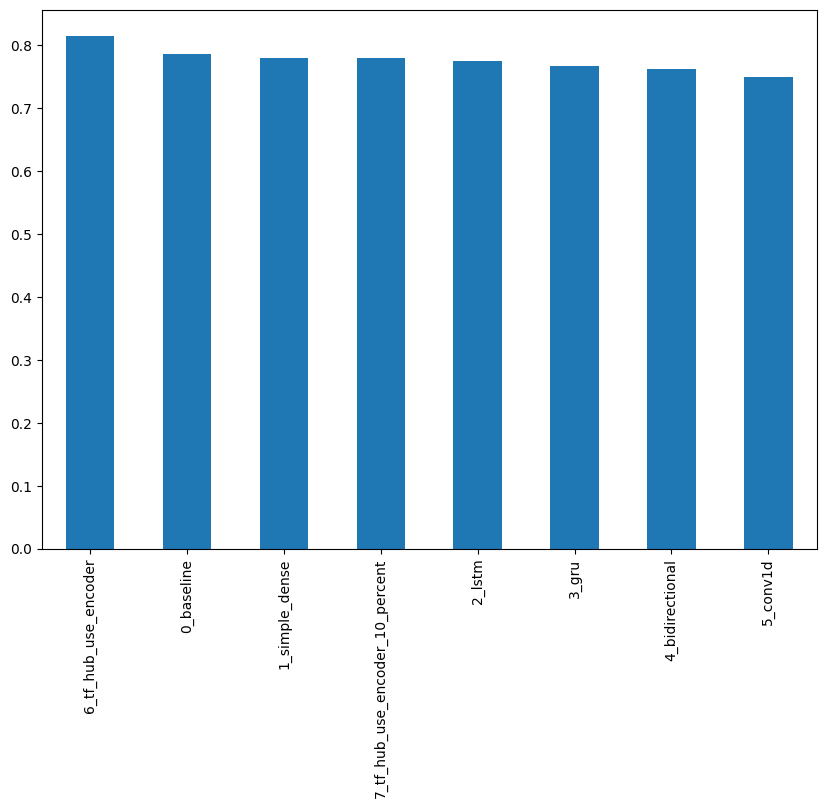

In [101]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Uploading our model training logs to TensorBoard.dev

We can further inspect our model's performance using TensorBoard.dev.

In [102]:
# # View TensorBoard logs of transfer learning modeling experiments (plus all of our models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs/ \
#   --name "NLP Modeling Experiments ZTM TF Course Video"\
#   --description "Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset"\
#   --one_shot # exit the uploader once uploading is finished

Now I've ran the cell above, my modeling are visible on TensorBoard.dev: https://tensorboard.dev/experiment/uJfKjehnSbu56yPbnk4H5g/


In [103]:
# See the previous TensorBoard Dev experiments you've run...
# !tensorboard dev list

In [104]:
# If you need to delete an experiment from TensorBoard, you can run the following:
# !tensorboard dev delete --experiment_id uJfKjehnSbu56yPbnk4H5g

## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SavedModel` format (this is the default when using TensorFlow)

In [105]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [106]:
# Load model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [107]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 12ms/step - loss: 0.4284 - accuracy: 0.8163


[0.42842182517051697, 0.8162729740142822]

Now let's save to the `SavedModel` format...


In [108]:
# Save TF Hub Senetence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [109]:
# Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [110]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 14ms/step - loss: 0.4284 - accuracy: 0.8163


[0.42842182517051697, 0.8162729740142822]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those will prediction probabilities closest to the opposite class)

For example if a sample should have a label of 0 but out model predicts a prediction probability of 0.999 (really close to 1) and vice versa.

In [111]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-08-17 16:37:45--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.187.128, 64.233.188.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  31.0MB/s    in 42s     

2023-08-17 16:38:28 (21.9 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.i

In [112]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 12ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [113]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10] # these shuold be in label format

24/24 [==============================] - 1s 11ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [114]:
# Create a DataFrame with validation sentences, validation labels and best performing model prediction labels + probabilities
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [115]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10] # these are false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835455
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [116]:
most_wrong.tail() # these are false negatives

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


Let's remind ourselves of the target labels...
* `0` = not disaster
* `1` = disaster

In [117]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957082748413
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769820332527161
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523001670837402
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.835454523563385
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272131681442261
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.8148159384727478
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

In [118]:
# Check the false negatives (model predicted 0 when should've been 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0.0, Prob: 0.06730345636606216
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.05507584661245346
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.05460338667035103
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.054596997797489166
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.04963729530572891
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.04391849786043167
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 0.0

## Making predictions on the test dataset

In [121]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expect a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-----\n")

1/1 [==============================] - 0s 79ms/step
Pred: 0, Prob: 0.059230703860521317
Text:
Be appalled O heavens at this
    be shocked be utterly desolate
    says the Lord
for my people have committed two evils:

-----

1/1 [==============================] - 0s 75ms/step
Pred: 0, Prob: 0.43314746022224426
Text:
If you decide to get rid of #flood damaged #furniture solid waste will pick it up for a fee. You can call #Tampa Solid Waste at 813-274-8811

-----

1/1 [==============================] - 0s 74ms/step
Pred: 0, Prob: 0.37449005246162415
Text:
TWIA board approves 5 percent rate hike: The Texas Windstorm Insurance Association (TWIA) Board of Directors v... http://t.co/NvxLJDsNkX

-----

1/1 [==============================] - 0s 76ms/step
Pred: 0, Prob: 0.4637115001678467
Text:
@lionofjudah1948 @AmericanJewry The Nazis pursued their ambitions to obliterate a religion in Europe #Israel is trying to do the same

-----

1/1 [==============================] - 0s 83ms/step
Pred: 0, 

## Your challenge... predicting on Tweets from the wild

Go to your favorite Twitter account and copy one of their latest Tweets.

Then pass that Tweet through our trained model.

Is that Tweet a disaster or not disaster (according to the model)? Is the model right or wrong?

## The speed/score tradeoff

In [127]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time - start_time # calculate how long predictions took to make
  time_per_pred = total_time / len(samples)
  return total_time, time_per_pred

In [128]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 12ms/step


(0.7059890330001508, 0.0009264947939634525)

In [129]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.03473745900009817, 4.5587216535561904e-05)

In [131]:
# Calculate results for pretrained GS model
model_6_pretrained_results = calculate_results(val_labels,
                                               model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

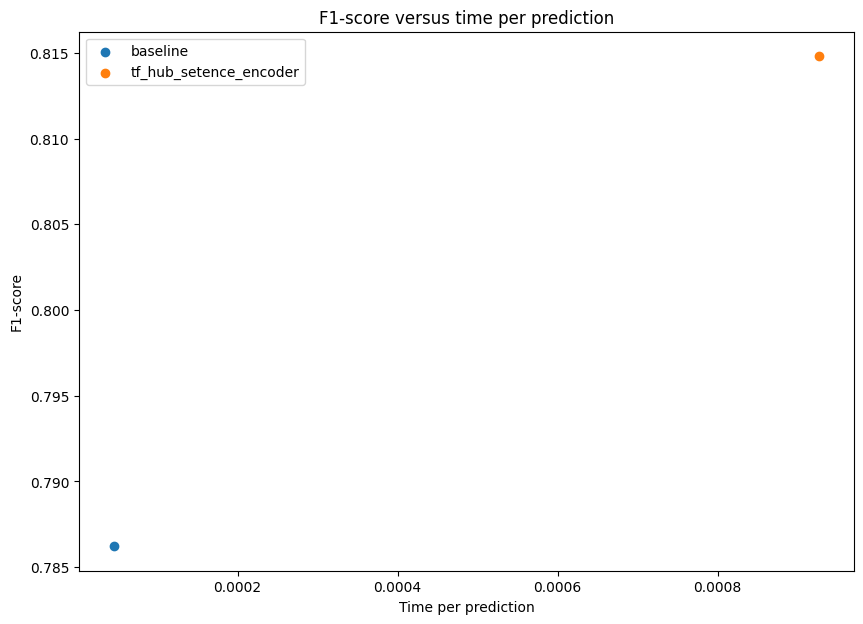

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_setence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score");